# Topic Modeling Techniques: Overview

## Intro

As more information becomes available, it becomes more difficult to search and find what we need.
The vast amount of electronic text available has stimulated the need for novel processing techniques in order to organize, search, understand and summarize the information contained therein.

Topic modeling is an unsupervised learning technique which provides methods for discovery of hidden semantic structures in a collection of documents.

The main idea is that there are a set of topics that describe the collection of documents and each document exhibits those topics in different proportions:
- Documents are a collection of topics
- Topics are a collection of words.

Probabilistic generative models, called topic models, are used to automatically learn these sets of words that best characterize the documents in a corpus. Each set of words represents a coherent theme or topic.

Topic models are very effective and useful in analyzing large collections of documents and tend to produce the best results when applied to texts that are not too short (such as tweets). For short text, topic modeling may not be the best technique because its main characteristics consists in being applied to text containing several topics.

A typical application of topic modeling consists in the following:
1. Apply topic modeling to discover the hidden topics that pervade a collection of documents
2. Tag each document according to those topics
3. Use tags as metadata to organize, summarize and search the desired documents.

In [1]:
# imports

import warnings

import matplotlib.pyplot as plt
import pyLDAvis.sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from helpers.NLPHelper import NLPHelper

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# parameters

random_seed = 42
max_df=0.95
min_df=3
max_features=5000

num_docs = 1000
num_top_words = 10
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
    'rec.sport.baseball'
]
num_topics = len(categories)

In [3]:
# input documents

newsgroups_dataset, _ = fetch_20newsgroups(
    shuffle=True, 
    random_state=random_seed,
    categories=categories,
    remove=('headers', 'footers', 'quotes'),
    return_X_y=True
)
documents = newsgroups_dataset[: num_docs]
len(documents)

1000

In [4]:
documents[0]

'\n\n\n        Yep... Alchemy works fine on my Tseng400+DAC, but I think I remember\nreading that it only displays in 15-bit or so.  Of course, that\'s still 32K\ncolors which is nothing to sneeze at.  Use the --v flag.\n\n\n--\n-----------------------------------------------------------------------------\n Neal Miller         | "Why not go mad?"  | millernw@craft.camp.clarkson.edu\n Clarkson University |     - Ford Prefect |     dark@craft.camp.clarkson.edu'

In [5]:
# pre-processing

nlp_helper = NLPHelper(language="english", stemming=True)

preprocessed_documents = [nlp_helper.preprocess_text(doc) for doc in documents]

In [6]:
preprocessed_documents[0]

'yep alchemi work fine tseng400dac think rememb read display 15bit cours that still 32k color noth sneez use v flag neal miller go mad millernwcraftcampclarksonedu clarkson univers ford prefect darkcraftcampclarksonedu'

In [7]:
# function definitions

def get_top_words_per_topic(topic_word_matrix, num_top_words, word_names):
    top_words_per_topic = {}
    for topic_idx, word_weights in enumerate(topic_word_matrix):
        top_word_indices = word_weights.argsort()[:-num_top_words - 1:-1]
        top_words_per_topic[topic_idx] = {word_names[word_idx]: word_weights[word_idx] for word_idx in top_word_indices}
    return top_words_per_topic

def get_main_topic_per_doc(doc_topic_matrix, documents, top_words_per_topic):
    top_topic_per_doc = {}
    for doc_idx, top_dist in enumerate(doc_topic_matrix):
        main_topic_idx = top_dist.argmax()
        top_topic_per_doc[doc_idx] = {
            "document": documents[doc_idx],
            "main_topic": tuple(top_words_per_topic[main_topic_idx].keys())
        }
    return top_topic_per_doc

def plot_topics(top_words_per_topic, num_topics, title):    
    fig, axes = plt.subplots(1, num_topics, figsize=(15, 5), sharex=True)
    axes = axes.flatten()
    for topic_idx, top_words in top_words_per_topic.items():
        ax = axes[topic_idx]
        ax.barh(tuple(top_words.keys()), top_words.values(), height=0.5)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 20})
        # rank from word with higher value
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=15)
        for i in 'top right'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=30)
    plt.subplots_adjust(top=0.80, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

## Latent Dirichlet Allocation (LDA)

The basic idea of LDA is that documents are produced from a mixture of topics which generate words based on their probability distribution. Therefore, given a dataset of documents, LDA backtracks and tries to figure out what topics would create the words of those documents in the first place.

Therefore, LDA states that the documents in a corpus talk about the same K topics but in different proportions (document-topic distribution) and that each latent topic has its own distribution (topic-word distribution) over the words in the corpus vocabulary:
- A topic-word distribution is a distribution of each latent topic over words. These distributions are shared between all documents. 
- A document-topic distribution is the distribution of each document over the topics. Each document has its own distribution over topics, independent of all other documents.

In detail:
1. Each document is a mixture of a small number of topics and each word creation is attributable to one of the document topics. Every word in the document was generated by sampling first a topic from the doc-topic distribution and then a word from the topic-word distribution.
2. LDA uses two Dirichlet-Multinomial distributions to model the relationships between documents and topics and the relationships between topics and words. The topic distribution is assumed to be a multinomial distribution Multi(theta) with Dirichlet as topic proportion theta. 
 - The sparse Dirichlet prior for the topic distribution encodes the intuition that each document covers only a small set of topics and that topics use only a small set of words frequently. This is a reasonable assumption.

However, LDA makes also another assumption. It is a bag-of-words model, so it assumes that the ordering of words in a document do not matter. This is typically false and this is one of the reasons why in some applications LDA may not perform well.

The output of LDA provides two probability matrices: 
1. The posterior probability distribution of each document over the topics, i.e. in what percentage each document talks about each topic, and 
2. The probability distribution of words in a given topic. This distribution is then used to select the top words for each topic as keywords for the topic.

Let's see how to apply LDA.

In [8]:
# training and inference

tf_vectorizer = CountVectorizer(
    max_df=max_df, 
    min_df=min_df,
    max_features=max_features,
    stop_words=None
)
tf_matrix = tf_vectorizer.fit_transform(preprocessed_documents)

lda_model = LatentDirichletAllocation(
    n_components=num_topics, 
    max_iter=10,
    learning_method='online',
    learning_offset=50,
    learning_decay=0.7,
    batch_size=128,
    random_state=random_seed
)

lda_model = lda_model.fit(tf_matrix) # for online method, it calls partial_fit()

topic_word_count = lda_model.components_
# normalize to get the topic-word distribution
topic_word_distribution = lda_model.components_ / lda_model.components_.sum(axis=1).reshape(num_topics,-1)

doc_topic_distribution = lda_model.transform(tf_matrix)

In [9]:
topic_word_count[0]

array([0.36944825, 1.22726656, 2.17746749, ..., 4.02952623, 1.53403963,
       0.27893158])

In [10]:
# get for each topic the top words, sorted according to their distribution

tf_feature_names = tf_vectorizer.get_feature_names()
lda_top_words_per_topic = get_top_words_per_topic(topic_word_distribution, num_top_words, tf_feature_names)

In [11]:
lda_top_words_per_topic[0]

{'imag': 0.012516026337201133,
 'use': 0.00958715454080504,
 'space': 0.008420141822155832,
 'data': 0.006932093632675712,
 'system': 0.006405813856212912,
 'program': 0.006096247634762452,
 'orbit': 0.005249635727805148,
 'file': 0.00492686094550417,
 'also': 0.004909620654789629,
 'softwar': 0.004589152781696655}

In [12]:
doc_topic_distribution[0]

array([0.2879657 , 0.01077524, 0.01053641, 0.68018266, 0.01053998])

In [13]:
# get for each doc the main topic, expressed by its top words

lda_top_topic_per_doc = get_main_topic_per_doc(doc_topic_distribution, preprocessed_documents, lda_top_words_per_topic)

In [14]:
lda_top_topic_per_doc[0]

{'document': 'yep alchemi work fine tseng400dac think rememb read display 15bit cours that still 32k color noth sneez use v flag neal miller go mad millernwcraftcampclarksonedu clarkson univers ford prefect darkcraftcampclarksonedu',
 'main_topic': ('year',
  'would',
  'like',
  'one',
  'good',
  'get',
  'dont',
  'know',
  'game',
  'last')}

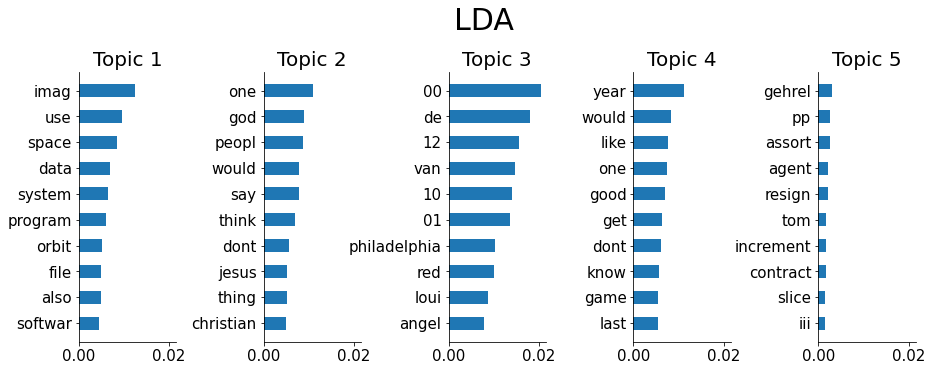

In [15]:
# simple visualization

plot_topics(lda_top_words_per_topic, num_topics, title="LDA")

In [16]:
# interactive pyLDAVis visualization

ldaVis = pyLDAvis.sklearn.prepare(lda_model, tf_matrix, tf_vectorizer, sort_topics=False)
# ldaVis
pyLDAvis.display(ldaVis)

## Non-Negative Matrix Factorization (NMF)

Non-Negative Matrix Factorization is a statistical method that factorizes a non-negative input matrix X into 2 non-negative matrices H and W whose product approximates X. This approximation is expressed in the form of a loss function ||X - WH|| whose norm is usually the frobenius norm or the kullback-leibler divergence.
In topic modeling:
- X represents the document-term matrix
- H represents the topic-word matrix
- W represents the document-topic matrix.

Let's see how to apply NMF.

In [17]:
# training and inference

tfidf_vectorizer = TfidfVectorizer(
    max_df=max_df, 
    min_df=min_df,
    max_features=max_features,
    stop_words=None
)

tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_documents)

nmf_model = NMF(
    n_components=num_topics,
    init='nndsvd',
    beta_loss='frobenius', # 'kullback-leibler' is a good alternative
    random_state=random_seed,
    alpha=0.1, 
    l1_ratio=0.5
)

nmf_model = nmf_model.fit(tfidf_matrix)

topic_word_matrix = nmf_model.components_

doc_topic_matrix = nmf_model.transform(tfidf_matrix)



In [18]:
topic_word_matrix[0]

array([0.        , 0.        , 0.        , ..., 0.04339898, 0.        ,
       0.        ])

In [19]:
# get for each topic the top words, sorted according to their distribution

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
nmf_top_words_per_topic = get_top_words_per_topic(topic_word_matrix, num_top_words, tfidf_feature_names)

In [20]:
nmf_top_words_per_topic[0]

{'god': 0.4446353176507813,
 'one': 0.39927454683203195,
 'peopl': 0.3677977827420788,
 'say': 0.36614291775467184,
 'think': 0.34732007927606756,
 'dont': 0.34405114047250507,
 'would': 0.33447802778996066,
 'thing': 0.26618965653845716,
 'like': 0.24754544703432685,
 'moral': 0.22453489271111593}

In [21]:
doc_topic_matrix[0]

array([0.04329628, 0.01422967, 0.        , 0.        , 0.00332981])

In [22]:
# get for each doc the main topic, expressed by its top words

nmf_top_topic_per_doc = get_main_topic_per_doc(doc_topic_matrix, preprocessed_documents, nmf_top_words_per_topic)

In [23]:
nmf_top_topic_per_doc[0]

{'document': 'yep alchemi work fine tseng400dac think rememb read display 15bit cours that still 32k color noth sneez use v flag neal miller go mad millernwcraftcampclarksonedu clarkson univers ford prefect darkcraftcampclarksonedu',
 'main_topic': ('god',
  'one',
  'peopl',
  'say',
  'think',
  'dont',
  'would',
  'thing',
  'like',
  'moral')}

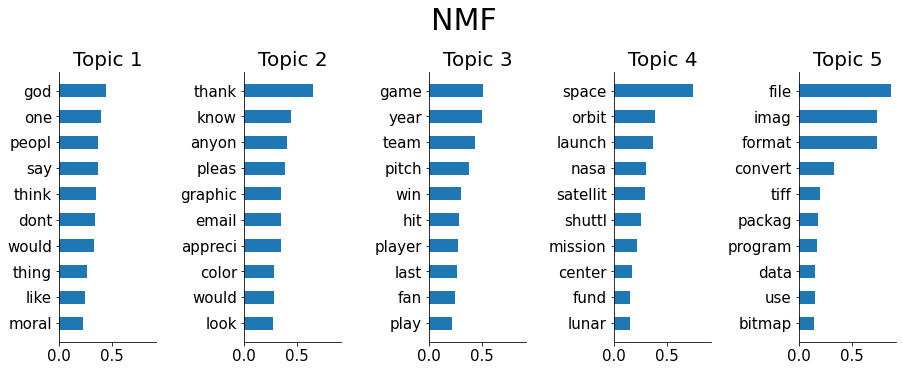

In [24]:
# simple visualization

plot_topics(nmf_top_words_per_topic, num_topics, title="NMF")

## Next Steps

For more info, check the following resources:
- scikit-learn [example](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py)